3. 영화 추천 시스템 구축
목표: 사용자 데이터를 기반으로 영화 추천 시스템을 개발한다.
데이터: movies.csv ratings.csv

미션 내용:
데이터 분석: 영화 평점 데이터를 로드하고 분석한다.
기술 분석: 특정 영화의 평균 평점, 장르별 선호도 등을 pandas로 분석하여 시각화한다.
협업 필터링: 사용자 기반 또는 아이템 기반의 협업 필터링 알고리즘을 구현한다.
성능 평가: RMSE, MAE 등의 지표로 추천 시스템의 성능을 평가한다.

In [1]:
import pandas as pd
import numpy as np
import os

# data 디렉토리 생성
if not os.path.exists('./data'):
    os.makedirs('./data')

# 각 장르에 따른 평점 범위를 지정 (Action은 높은 평점, Drama는 낮은 평점 등)
genre_rating_ranges = {
    'Action': (3.0, 5.0),
    'Comedy': (1.5, 2.5),
    'Drama': (1.5, 3.5),
    'Horror': (2.0, 4.0),
    'Romance': (2.0, 4.5)
}

# movies.csv 데이터 생성
movies_data = {
    'movieId': np.arange(1, 2000),
    'title': [f'Movie {i}' for i in range(1, 2000)],
    'genres': np.random.choice(list(genre_rating_ranges.keys()), size=1999)
}

movies_df = pd.DataFrame(movies_data)
movies_df.to_csv('./data/movies.csv', index=False)
print("movies.csv 파일 생성 완료!")

# ratings.csv 데이터 생성
ratings_data = {
    'userId': np.random.randint(1, 1000, size=10000),
    'movieId': np.random.randint(1, 2000, size=10000),
}

ratings_df = pd.DataFrame(ratings_data)

# 각 영화의 장르에 따라 평점 분포를 조정하여 평점 생성
def generate_rating(movieId):
    genre = movies_df[movies_df['movieId'] == movieId]['genres'].values[0]
    low, high = genre_rating_ranges[genre]
    return np.random.uniform(low, high)

ratings_df['rating'] = ratings_df['movieId'].apply(generate_rating)
ratings_df['timestamp'] = np.random.randint(1_000_000_000, 1_100_000_000, size=10000)

ratings_df.to_csv('./data/ratings.csv', index=False)
print("ratings.csv 파일 생성 완료!")

# 장르별 선호도 분석
genre_data = ratings_df.merge(movies_df, on='movieId')  # ratings와 movies 데이터프레임을 병합
genre_preferences = genre_data.groupby('genres')['rating'].mean().reset_index()

print("\n장르별 평균 평점:")
print(genre_preferences)


movies.csv 파일 생성 완료!
ratings.csv 파일 생성 완료!

장르별 평균 평점:
    genres    rating
0   Action  4.009443
1   Comedy  1.993260
2    Drama  2.502664
3   Horror  3.015875
4  Romance  3.282259


1. 데이터 분석
먼저, 제공된 ratings.csv와 movies.csv 파일을 로드하고 특정 영화의 평균 평점 및 장르별 선호도를 분석합니다.

In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# CSV 파일 불러오기
ratings = pd.read_csv('./data/ratings.csv')  # 평점 데이터
movies = pd.read_csv('./data/movies.csv')    # 영화 데이터

# 특정 영화의 평균 평점 계산 (실제 존재하는 영화 제목 사용)
movie_title = 'Movie 1'  # 실제 존재하는 제목

# 해당 영화 ID 가져오기
movie_id_series = movies[movies['title'] == movie_title]['movieId']

if not movie_id_series.empty:
    movie_id = movie_id_series.values[0]  # 영화 ID 가져오기
    average_rating = ratings[ratings['movieId'] == movie_id]['rating'].mean()  # 평균 평점 계산
    print(f"{movie_title}의 평균 평점: {average_rating:.2f}")
else:
    print(f"{movie_title}이(가) movies 데이터프레임에 존재하지 않습니다.")

# 장르별 선호도 분석
genre_data = ratings.merge(movies, on='movieId')  # ratings와 movies 데이터프레임을 병합
genre_preferences = genre_data.groupby('genres')['rating'].mean().reset_index()

print("\n장르별 평균 평점:")
print(genre_preferences)


Movie 1의 평균 평점: 4.08

장르별 평균 평점:
    genres    rating
0   Action  4.009443
1   Comedy  1.993260
2    Drama  2.502664
3   Horror  3.015875
4  Romance  3.282259


2. 시각화 (Matplotlib, Seaborn 활용)

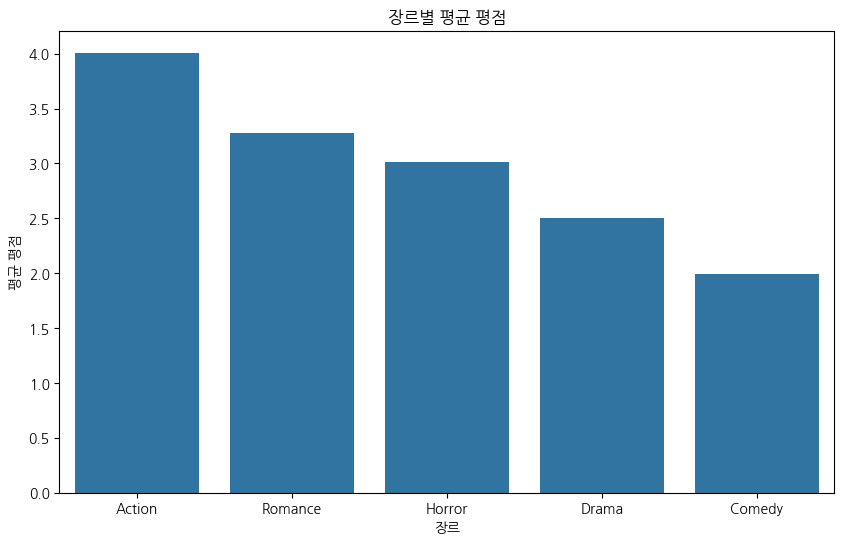

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (필요 시)
plt.rc('font', family='NanumGothic')

# 장르별 선호도 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='genres', y='rating', data=genre_preferences.sort_values(by='rating', ascending=False))
plt.title("장르별 평균 평점")
plt.xlabel("장르")
plt.ylabel("평균 평점")
plt.show()


3. 협업 필터링 기반 영화 추천 (코사인 유사도 사용)

In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# 중복된 (userId, movieId) 조합에 대해 평균 평점 계산
ratings_unique = ratings.groupby(['userId', 'movieId']).agg({'rating': 'mean'}).reset_index()

# 영화-사용자 행렬 생성
movie_user_matrix = ratings_unique.pivot(index='movieId', columns='userId', values='rating').fillna(0)

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(movie_user_matrix)

# DataFrame으로 변환
similarity_df = pd.DataFrame(similarity_matrix, index=movie_user_matrix.index, columns=movie_user_matrix.index)

# 특정 영화에 대한 추천 영화 찾기 (예: 'Movie 1')
movie_id = movies[movies['title'] == movie_title]['movieId'].values[0]
similar_movies = similarity_df[movie_id].sort_values(ascending=False)[1:6]  # 상위 5개 영화 추천

# 추천 영화 출력
recommended_movie_ids = similar_movies.index
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]

print("\n추천 영화:")
print(recommended_movies[['title', 'genres']])



추천 영화:
           title   genres
293    Movie 294   Action
482    Movie 483   Comedy
1306  Movie 1307  Romance
1699  Movie 1700    Drama
1813  Movie 1814   Action
